# Deep N-grams (GRU LM & LSTM LM)

In this Notebook you will explore Recurrent Neural Networks `RNN`.

In this notebook we will apply the following steps:
- Convert a line of text into a tensor
- Create a tensorflow dataset
- Define a GRU and LSTM model using `TensorFlow`
- Train the models using `TensorFlow`
- Compute the accuracy of our models using the perplexity
- Generate text using our own models




## Overview

In this Notebook, we'll delve into the world of text generation using Recurrent Neural Networks (RNNs). The primary objective is to predict the next set of characters based on the preceding ones. This seemingly straightforward task holds immense practicality in applications like predictive text and creative writing.

The journey unfolds as follows:

- Data Preprocessing: we'll start by converting lines of text into numerical tensors, making them machine-readable.

- Dataset Creation: Next, we'll create a TensorFlow dataset, which will serve as the backbone for supplying data to our models.

- Neural Network Training: Our models will be trained to predict the next set of characters, specifying the desired output length.

- Character Embeddings: Character embeddings will be employed to represent each character as a vector, a fundamental technique in natural language processing.

- GRU & LSTM Models: Our models utilizes a Gated Recurrent Unit (GRU) and Long Short Term Memory model (LSTM) to process character embeddings and make sequential predictions. T

- Prediction Process: The model's predictions are achieved through a linear layer and log-softmax computation.

This overview sets the stage for our exploration of text generation. Get ready to unravel the secrets of language and embark on a journey into the realm of creative writing and predictive text generation.

And as usual let's start by importing all the required libraries.

In [4]:
import os
import traceback
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import shutil
import numpy as np
import random as  rnd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input

from termcolor import colored

# set random seed
rnd.seed(32)

In [5]:
dirname = './'
filename = 'shakespeare_data.txt'
lines = [] # storing all the lines in a variable.

counter = 0

with open(os.path.join(dirname, filename)) as files:
    for line in files:
        # remove leading and trailing whitespace
        pure_line = line.strip()#.lower()

        # if pure_line is not the empty string,
        if pure_line:
            # append it to the list
            lines.append(pure_line)

n_lines = len(lines)
print(f"Number of lines: {n_lines}")

Number of lines: 125097


Let's examine a few lines from the corpus. Pay close attention to the structure and style employed by Shakespeare in this excerpt. Observe that character names are written in uppercase, and each line commences with a capital letter. Your task in this exercise is to construct a generative model capable of emulating this particular structural style.

In [6]:
print("\n".join(lines[506:514]))

BENVOLIO	Here were the servants of your adversary,
And yours, close fighting ere I did approach:
I drew to part them: in the instant came
The fiery Tybalt, with his sword prepared,
Which, as he breathed defiance to my ears,
He swung about his head and cut the winds,
Who nothing hurt withal hiss'd him in scorn:
While we were interchanging thrusts and blows,



### 1.2 - Create the vocabulary

In the following code cell, we will create the vocabulary for text processing. The vocabulary is a crucial component for understanding and processing text data. Here's what the code does:

- Concatenate all the lines in our dataset into a single continuous text, separated by line breaks.

- Identify and collect the unique characters that make up the text. This forms the basis of our vocabulary.

- To enhance the vocabulary, introduce two special characters:

  - [UNK]: This character represents any unknown or unrecognized characters in the text.
  - "" (empty character): This character is used for padding sequences when necessary.
- The code concludes with the display of statistics, showing the total count of unique characters in the vocabulary and providing a visual representation of the complete character set.

In [7]:
text = "\n".join(lines)
# The unique characters in the file
vocab = sorted(set(text))
vocab.insert(0,"[UNK]") # Add a special character for any unknown
vocab.insert(1,"") # Add the empty character for padding.

print(f'{len(vocab)} unique characters')
print(" ".join(vocab))

82 unique characters
[UNK]  	 
   ! $ & ' ( ) , - . 0 1 2 3 4 5 6 7 8 9 : ; ? A B C D E F G H I J K L M N O P Q R S T U V W X Y Z [ ] a b c d e f g h i j k l m n o p q r s t u v w x y z |



### 1.3 - Convert a Line to Tensor

Now that we have our list of lines, we will convert each character in that list to a number using the order given by our vocabulary. we can use [`tf.strings.unicode_split`](https://www.tensorflow.org/api_docs/python/tf/strings/unicode_split) to split the text into characters.

In [8]:
line = "Hello world!"
chars = tf.strings.unicode_split(line, input_encoding='UTF-8')
print(chars)

tf.Tensor([b'H' b'e' b'l' b'l' b'o' b' ' b'w' b'o' b'r' b'l' b'd' b'!'], shape=(12,), dtype=string)


Using your vocabulary, you can convert the characters given by `unicode_split` into numbers. The number will be the index of the character in the given vocabulary.

In [9]:
print(vocab.index('a'))
print(vocab.index('e'))
print(vocab.index('i'))
print(vocab.index('o'))
print(vocab.index('u'))
print(vocab.index(' '))
print(vocab.index('2'))
print(vocab.index('3'))

55
59
63
69
75
4
16
17


Tensorflow has a function [`tf.keras.layers.StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup)  that does this efficiently for list of characters. Note that the output object is of type `tf.Tensor`. Here is the result of applying the StringLookup function to the characters of "Hello world"

In [10]:
ids = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)(chars)
print(ids)

tf.Tensor([34 59 66 66 69  4 77 69 72 66 58  5], shape=(12,), dtype=int64)



### 1 - line_to_tensor

Alright! now that we know what to do, let's wrap it into a function :

In [11]:

def line_to_tensor(line, vocab):
    """
    Converts a line of text into a tensor of integer values representing characters.

    Args:
        line (str): A single line of text.
        vocab (list): A list containing the vocabulary of unique characters.

    Returns:
        tf.Tensor(dtype=int64): A tensor containing integers (unicode values) corresponding to the characters in the `line`.
    """


    # Split the input line into individual characters
    chars = tf.strings.unicode_split(line, input_encoding='UTF-8')
    # Map characters to their respective integer values using StringLookup
    ids = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)(chars)


    return ids

In [12]:
# Test the function
tmp_ids = line_to_tensor('abc xyz', vocab)
print(f"Result: {tmp_ids}")
print(f"Output type: {type(tmp_ids)}")

Result: [55 56 57  4 78 79 80]
Output type: <class 'tensorflow.python.framework.ops.EagerTensor'>


we will also need a function that produces text given a numeric tensor. This function will be useful for inspection when we use your models to generate new text, because we will be able to see words rather than lists of numbers. The function will use the inverse Lookup function `tf.keras.layers.StringLookup` with `invert=True` in its parameters.

In [13]:
def text_from_ids(ids, vocab):
    """
    Converts a tensor of integer values into human-readable text.

    Args:
        ids (tf.Tensor): A tensor containing integer values (unicode IDs).
        vocab (list): A list containing the vocabulary of unique characters.

    Returns:
        str: A string containing the characters in human-readable format.
    """
    # Initialize the StringLookup layer to map integer IDs back to characters
    chars_from_ids = tf.keras.layers.StringLookup(vocabulary=vocab, invert=True, mask_token=None)

    # Use the layer to decode the tensor of IDs into human-readable text
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Use the function for decoding the tensor produced by "Hello world!"

In [14]:
text_from_ids(ids, vocab).numpy()

b'Hello world!'


### 1.4 - Prepare our data for training and testing
As usual, we will need some data for training our model, and some data for testing its performance. So, we will use 124097 lines for training and 1000 lines for testing.

In [15]:
train_lines = lines[:-1000] # Leave the rest for training
eval_lines = lines[-1000:] # Create a holdout validation set

print(f"Number of training lines: {len(train_lines)}")
print(f"Number of validation lines: {len(eval_lines)}")

Number of training lines: 124097
Number of validation lines: 1000



### 1.5 - TensorFlow dataset

Most of the time in Natural Language Processing, and AI in general we use batches when training our models. Here, we will build a dataset that takes in some text and returns a batch of text fragments (Not necesarly full sentences) that you will use for training.

- The generator will produce text fragments encoded as numeric tensors of a desired length (batches)

Once we create the dataset, we can iterate on it like this:

```
data_generator.take(1)
```

This generator returns the data in a format that we could directly use in your model when computing the feed-forward of our algorithm. This batch dataset generator returns batches of data in an endless way.

In order to get a dataset generator that produces batches of fragments from the corpus, we first need to convert the whole text into a single line, and then transform it into a single big tensor. This is only possible if our data fits completely into memory.


In [16]:
all_ids = line_to_tensor("\n".join(["Hello world!", "Generative AI"]), vocab)
all_ids

<tf.Tensor: shape=(26,), dtype=int64, numpy=
array([34, 59, 66, 66, 69,  4, 77, 69, 72, 66, 58,  5,  3, 33, 59, 68, 59,
       72, 55, 74, 63, 76, 59,  4, 27, 35])>

Create a dataset out of a tensor like input. This initial dataset will dispatch numbers in packages of a specified length. For example, we can use it for getting the 10 first encoded characters of our dataset. To make it easier to read, we can use the `text_from_ids` function.

In [17]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
print([text_from_ids([ids], vocab).numpy() for ids in ids_dataset.take(10)])

[b'H', b'e', b'l', b'l', b'o', b' ', b'w', b'o', b'r', b'l']


But we can configure this dataset to produce batches of the same size each time. We could use this functionality to produce text fragments of a desired size (`seq_length + 1`). We will explain later why we need an extra character into the sequence.

In [18]:
seq_length = 10
data_generator = ids_dataset.batch(seq_length + 1, drop_remainder=True)

we can verify that the data generator produces encoded fragments of text of the desired length. For example, let's ask the generator to produce 2 batches of data using the function `data_generator.take(2)`

In [19]:
for seq in data_generator.take(2):
    print(seq)

tf.Tensor([34 59 66 66 69  4 77 69 72 66 58], shape=(11,), dtype=int64)
tf.Tensor([ 5  3 33 59 68 59 72 55 74 63 76], shape=(11,), dtype=int64)


But as usual, it is easier to understand if we print it in human readable characters using the 'text_from_ids' function.

In [20]:
i = 1
for seq in data_generator.take(2):
    print(f"{i}. {text_from_ids(seq, vocab).numpy()}")
    i = i + 1

1. b'Hello world'
2. b'!\nGenerativ'



### 1.6 - Create the input and the output for your model

In this part we have to predict the next character in a sequence. The following function creates 2 tensors, each with a length of `seq_length` out of the input sequence of lenght `seq_length + 1`. The first one contains the first `seq_length` elements and the second one contains the last `seq_length` elements. For example, if you split the sequence `['H', 'e', 'l', 'l', 'o']`, we will obtain the sequences `['H', 'e', 'l', 'l']` and `['e', 'l', 'l', 'o']`.

In [21]:
def split_input_target(sequence):
    """
    Splits the input sequence into two sequences, where one is shifted by one position.

    Args:
        sequence (tf.Tensor or list): A list of characters or a tensor.

    Returns:
        tf.Tensor, tf.Tensor: Two tensors representing the input and output sequences for the model.
    """
    # Create the input sequence by excluding the last character
    input_text = sequence[:-1]
    # Create the target sequence by excluding the first character
    target_text = sequence[1:]

    return input_text, target_text

Look the result using the following sequence of characters

In [22]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

The first sequence will be the input and the second sequence will be the expected output

Now, put all this together into a function to create your batch dataset generator


### 2 - create_batch_dataset


- Join all the input lines into a single string. When we have a big dataset, we would better use a flow from directory or any other kind of generator.
- Transform the input text into numeric tensors
- Create a TensorFlow DataSet from our numeric tensors: Just feed the numeric tensors into the function [`tf.data.Dataset.from_tensor_slices`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
- Make the dataset produce batches of data that will form a single sample each time. This is, make the dataset produce a sequence of `seq_length + 1`, rather than single numbers at each time. we can do it using the `batch` function of the already created dataset. we must specify the length of the produced sequences (`seq_length + 1`). So, the sequence length produced by the dataset will `seq_length + 1`. It must have that extra element since you will get the input and the output sequences out of the same element. `drop_remainder=True` will drop the sequences that do not have the required length. This could happen each time that the dataset reaches the end of the input sequence.
- Use the `split_input_target` to split each element produced by the dataset into the mentioned input and output sequences.The input will have the first `seq_length` elements, and the output will have the last `seq_length`. So, after this step, the dataset generator will produce batches of pairs (input, output) sequences.
- Create the final dataset, using `dataset_xy` as the starting point. we will configure this dataset to shuffle the data during the generation of the data with the specified BUFFER_SIZE. For performance reasons, we would like that tensorflow pre-process the data in parallel with training. That is called [`prefetching`](https://www.tensorflow.org/guide/data_performance#prefetching)

In [23]:

def create_batch_dataset(lines, vocab, seq_length=100, batch_size=64):
    """
    Creates a batch dataset from a list of text lines.

    Args:
        lines (list): A list of strings with the input data, one line per row.
        vocab (list): A list containing the vocabulary.
        seq_length (int): The desired length of each sample.
        batch_size (int): The batch size.

    Returns:
        tf.data.Dataset: A batch dataset generator.
    """
    # Buffer size to shuffle the dataset
    # (TF data is designed to work with possibly infinite sequences,
    # so it doesn't attempt to shuffle the entire sequence in memory. Instead,
    # it maintains a buffer in which it shuffles elements).
    BUFFER_SIZE = 10000

    # For simplicity, just join all lines into a single line
    single_line_data  = "\n".join(lines)

    # Convert your data into a tensor using the given vocab
    all_ids = line_to_tensor(single_line_data, vocab)
    # Create a TensorFlow dataset from the data tensor
    ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
    # Create a batch dataset
    data_generator = ids_dataset.batch(seq_length + 1, drop_remainder=True)
    # Map each input sample using the split_input_target function
    dataset_xy = data_generator.map(split_input_target)

    # Assemble the final dataset with shuffling, batching, and prefetching
    dataset = (
        dataset_xy
        .shuffle(BUFFER_SIZE)
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.experimental.AUTOTUNE)
        )


    return dataset

In [24]:
# test the function
tf.random.set_seed(1)
dataset = create_batch_dataset(train_lines[1:100], vocab, seq_length=16, batch_size=2)

print("Prints the elements into a single batch. The batch contains 2 elements: ")

for input_example, target_example in dataset.take(1):
    print("\n\033[94mInput0\t:", text_from_ids(input_example[0], vocab).numpy())
    print("\n\033[93mTarget0\t:", text_from_ids(target_example[0], vocab).numpy())

    print("\n\n\033[94mInput1\t:", text_from_ids(input_example[1], vocab).numpy())
    print("\n\033[93mTarget1\t:", text_from_ids(target_example[1], vocab).numpy())

Prints the elements into a single batch. The batch contains 2 elements: 

Input0	: b'and sight distra'

Target0	: b'nd sight distrac'


Input1	: b'when in his fair'

Target1	: b'hen in his fair '



### 1.7 - Create the training dataset

Now, we can generate your training dataset using the functions defined above. This will produce pairs of input/output tensors each time the batch generator creates an entry.

In [25]:
# Batch size
BATCH_SIZE = 64
dataset = create_batch_dataset(train_lines, vocab, seq_length=100, batch_size=BATCH_SIZE)


## 2 - Defining the GRU Language Model (GRULM) & LSTM Language Model (LSTMLM)

Now that we have the input and output tensors, we will go ahead and initialize our models. We will be implementing the `GRULM` & `LSTMLM`, To implement this model, we will be using `TensorFlow`. Instead of implementing the `GRU` & `LSTM` from scratch, we will use the necessary methods from a built-in package. You can use the following packages when constructing the model:

- `tf.keras.layers.Embedding`: Initializes the embedding. In this case it is the size of the vocabulary by the dimension of the model. [docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)  
    - `Embedding(vocab_size, embedding_dim)`.
    - `vocab_size` is the number of unique words in the given vocabulary.
    - `embedding_dim` is the number of elements in the word embedding (some choices for a word embedding size range from 150 to 300, for example).
___

- `tf.keras.layers.GRU`: `TensorFlow` GRU layer. [docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)) Builds a traditional GRU of rnn_units with dense internal transformations. You can read the paper here: https://arxiv.org/abs/1412.3555
    - `units`: Number of recurrent units in the layer. It must be set to `rnn_units`
    - `return_sequences`: It specifies if the model returns a sequence of predictions. Set it to `True`
    - `return_state`: It specifies if the model must return the last internal state along with the prediction. Set it to `True`
___
- `tf.keras.layers.LSTM`: `TensorFlow` LSTM layer. [docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)) Builds a traditional LSTM of rnn_units with dense internal transformations.
    - `units`: Number of recurrent units in the layer. It must be set to `rnn_units`
    - `return_sequences`: It specifies if the model returns a sequence of predictions. Set it to `True`
    - `return_state`: It specifies if the model must return the last internal state along with the prediction. Set it to `True`
___

- `tf.keras.layers.Dense`: A dense layer. [docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). You must set the following parameters:
    - `units`: Number of units in the layer. It must be set to `vocab_size`
    - `activation`: It must be set to `log_softmax` function as described in the next line.
___

- `tf.nn.log_softmax`: Log of the output probabilities. [docs](https://www.tensorflow.org/api_docs/python/tf/nn/log_softmax)
    - You don't need to set any parameters, just set the activation parameter as `activation=tf.nn.log_softmax`.
___


###  3.1 - GRULM



In [26]:

class GRULM(tf.keras.Model):
    """
    A GRU-based language model that maps from a tensor of tokens to activations over a vocabulary.

    Args:
        vocab_size (int, optional): Size of the vocabulary. Defaults to 256.
        embedding_dim (int, optional): Depth of embedding. Defaults to 256.
        rnn_units (int, optional): Number of units in the GRU cell. Defaults to 128.

    Returns:
        tf.keras.Model: A GRULM language model.
    """
    def __init__(self, vocab_size=256, embedding_dim=256, rnn_units = 128):
        super().__init__(self)

        # Create an embedding layer to map token indices to embedding vectors
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define a GRU (Gated Recurrent Unit) layer for sequence modeling
        self.gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        # Apply a dense layer with log-softmax activation to predict next tokens
        self.dense = tf.keras.layers.Dense(vocab_size,activation=tf.nn.log_softmax)


    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        # Map input tokens to embedding vectors
        x = self.embedding(x, training=training)
        if states is None:
            # Get initial state from the GRU layer
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        # Predict the next tokens and apply log-softmax activation
        x = self.dense(x, training=training)
        if return_state:
            return x, states
        else:
            return x

In [27]:
class LSTMLM(tf.keras.Model):
    """
    A LSTM-based language model that maps from a tensor of tokens to activations over a vocabulary.

    Args:
        vocab_size (int, optional): Size of the vocabulary. Defaults to 256.
        embedding_dim (int, optional): Depth of embedding. Defaults to 256.
        rnn_units (int, optional): Number of units in the GRU cell. Defaults to 128.

    Returns:
        tf.keras.Model: A LSTMLM language model.
    """
    def __init__(self, vocab_size=256, embedding_dim=256, rnn_units = 128):
        super().__init__(self)



        # Create an embedding layer to map token indices to embedding vectors
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define a LSTM layer for sequence modeling
        self.LSTM = tf.keras.layers.LSTM(rnn_units, return_sequences=True, return_state=True)
        # Apply a dense layer with log-softmax activation to predict next tokens
        self.dense = tf.keras.layers.Dense(vocab_size,activation=tf.nn.log_softmax)


    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        # Map input tokens to embedding vectors
        x = self.embedding(x, training=training)

        if states is None:
            # If no initial states, let the LSTM layer create them
            outputs, state_h, state_c = self.LSTM(x, training=training)
        else:
        # If initial states are provided, use them
            outputs, state_h, state_c = self.LSTM(x, initial_state=states, training=training)

        # Predict the next tokens and apply log-softmax activation
        x = self.dense(outputs, training=training)

        if return_state:
            # Return the output and states if return_state is True
            return x, [state_h, state_c]
        else:
            # Only return the output otherwise
            return x

Now, you can define a new GRULM & LSTMLM models. we must set the `vocab_size` to 82; the size of the embedding `embedding_dim` to 256, and the number of units that will have our recurrent neural network `rnn_units` to 512

In [28]:
# Length of the vocabulary in StringLookup Layer

vocab_size = 82

# The embedding dimension

embedding_dim = 256

# RNN layers

rnn_units = 512

model_gru = GRULM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units = rnn_units)

In [29]:
# Length of the vocabulary in StringLookup Layer

vocab_size = 82

# The embedding dimension

embedding_dim = 256

# RNN layers

rnn_units = 512


model_lstm = LSTMLM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units = rnn_units)

In [30]:
# testing our model

try:
    # Simulate inputs of length 100. This allows to compute the shape of all inputs and outputs of our network
    model_gru.build(input_shape=(BATCH_SIZE, 100))
    model_gru.call(Input(shape=(100)))
    model_gru.summary()
except:
    print("\033[91mError! \033[0mA problem occurred while building your model. This error can occur due to wrong initialization\n\n")
    traceback.print_exc()

Model: "grulm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 256)          20992     
                                                                 
 gru (GRU)                   [(None, 100, 512),        1182720   
                              (None, 512)]                       
                                                                 
 dense (Dense)               (None, 100, 82)           42066     
                                                                 
Total params: 1245778 (4.75 MB)
Trainable params: 1245778 (4.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# testing our model


try:
    # Simulate inputs of length 100. This allows to compute the shape of all inputs and outputs of our network


    model_lstm.build(input_shape=(BATCH_SIZE, 100))
    model_lstm.call(Input(shape=(100)))
    model_lstm.summary()
except:
    print("\033[91mError! \033[0mA problem occurred while building your model. This error can occur due to wrong initialization \n\n")
    traceback.print_exc()

Model: "lstmlm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 256)          20992     
                                                                 
 lstm (LSTM)                 [(None, 100, 512),        1574912   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
 dense_1 (Dense)             (None, 100, 82)           42066     
                                                                 
Total params: 1637970 (6.25 MB)
Trainable params: 1637970 (6.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now, let's use the GRU model for predicting the next character using the untrained model. At the begining the model will generate only gibberish.

In [32]:
for input_example_batch, target_example_batch in dataset.take(1):
    print("Input: ", input_example_batch[0].numpy()) # Lets use only the first sequence on the batch
    example_batch_predictions = model_gru(tf.constant([input_example_batch[0].numpy()]))
    print("\n",example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

Input:  [55  4 57 55 75 73 59 66 59 73 73  4 60 55 68 74 55 73 79 11  3 27 68 58
  4 57 62 63 66 58 63 73 62  4 59 72 72 69 72 11  4 74 62 55 74  4 74 62
 59 79  4 55 72 59  4 55 60 72 55 63 58 25  3 28 63 58 73  4 74 62 59 67
  4 66 59 55 76 59  4 71 75 55 65 63 68 61 11  4 56 63 58 73  4 74 62 59
 67  4 60 59]

 (1, 100, 82) # (batch_size, sequence_length, vocab_size)


Let's try the LSTM model as well

In [33]:
for input_example_batch, target_example_batch in dataset.take(1):
    print("Input: ", input_example_batch[0].numpy()) # Lets use only the first sequence on the batch
    example_batch_predictions = model_lstm(tf.constant([input_example_batch[0].numpy()]))
    print("\n",example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

Input:  [63 58  4 62 59 72 59 11  3 27  4 72 63 68 61  4 63 68  4 57 62 55 73 59
  4 69 60  4 79 69 75 24  4 73 69  4 58 63 58  4 35  4 55 56 75 73 59  3
 39 79 73 59 66 60 11  4 67 79  4 73 59 72 76 55 68 74  4 55 68 58 11  4
 35  4 60 59 55 72  4 67 59 11  4 79 69 75 24  3 47 68 58 59 72  4 79 69
 75 72  4 62]

 (1, 100, 82) # (batch_size, sequence_length, vocab_size)


The output size is (1, 100, 82). We predicted only on the first sequence generated by the batch generator. 100 is the number of predicted characters. It has exactly the same length as the input. And there are 82 values for each predicted character. Each of these 82 real values are related to the logarithm likelihood of each character to be the next one in the sequence. The bigger the value, the higher the likelihood. As the network is not trained yet, all those values must be very similar and random. Just check the values for the last prediction on the sequence.

In [34]:
example_batch_predictions[0][99].numpy()

array([-4.419118 , -4.412833 , -4.414311 , -4.3991838, -4.401638 ,
       -4.3973403, -4.402481 , -4.422451 , -4.3978863, -4.400891 ,
       -4.416775 , -4.4076934, -4.3987746, -4.4216504, -4.3982496,
       -4.4023438, -4.405349 , -4.4075117, -4.406863 , -4.416502 ,
       -4.4014177, -4.40884  , -4.3937726, -4.4107   , -4.41072  ,
       -4.4062586, -4.4070373, -4.4079137, -4.4231052, -4.401702 ,
       -4.399208 , -4.4121933, -4.404532 , -4.4031453, -4.4102764,
       -4.3956776, -4.394757 , -4.425828 , -4.4202027, -4.4102793,
       -4.4014764, -4.405326 , -4.408773 , -4.403935 , -4.4135666,
       -4.4065323, -4.4056115, -4.4036484, -4.403766 , -4.406415 ,
       -4.406102 , -4.40142  , -4.418734 , -4.4140863, -4.397257 ,
       -4.4230905, -4.41517  , -4.4022083, -4.4033437, -4.4042015,
       -4.408529 , -4.3947854, -4.394715 , -4.4031367, -4.4010143,
       -4.401338 , -4.403673 , -4.408378 , -4.403745 , -4.4024844,
       -4.4252534, -4.4116216, -4.400852 , -4.416922 , -4.3971

And the simplest way to choose the next character is by getting the index of the element with the highest likelihood. So, for instance, the prediction for the last characeter would be:

In [35]:
last_character = tf.math.argmax(example_batch_predictions[0][99])
print(last_character.numpy())

22


And the prediction for the whole sequence would be:

In [36]:
sampled_indices = tf.math.argmax(example_batch_predictions[0], axis=1)
print(sampled_indices.numpy())

[32 71 80 80 54  3 54 11 43 80 80 69 69 69 69 50 50 69 69 34 14 14 20 34
 34 34 40 61 69 40 43 40 43 68 68  5 61 68 71 61 61 61 61 74 59 20 42 47
 47 77  5 47 47 40 48 64 43 63 43 64 34 22 22 20 69 34 34 34 34 34 71 16
 24 43 61 72 34 69 69 69 22 35 43 69 35 35 35 35 35 35 42 42 22 16 77 77
 77 22 22 22]


Those 100 numbers represent 100 predicted characters. However, humans cannot read this. So, let's print the input and output sequences using our `text_from_ids` function, to check what is going on.

In [37]:
print("Input:\n", text_from_ids(input_example_batch[0], vocab))
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices, vocab))

Input:
 tf.Tensor(b'id here,\nA ring in chase of you: so did I abuse\nMyself, my servant and, I fear me, you:\nUnder your h', shape=(), dtype=string)

Next Char Predictions:
 tf.Tensor(b'Fqzz]\n],QzzooooXXooH006HHHNgoNQNQnn!gnqggggte6PUUw!UUNVjQiQjH886oHHHHHq2:QgrHooo8IQoIIIIIIPP82www888', shape=(), dtype=string)


As expected, the untrained model just produces random text as response of the given input. It is also important to note that getting the index of the maximum score is not always the best choice. In the last part of the notebook we will see another way to do it.


## 3 - Training

Now we are going to train our models. As usual, we have to define the cost function and the optimizer. We will use the following built-in functions provided by TensorFlow:

- [`tf.losses.SparseCategoricalCrossentropy()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy): The Sparce Categorical Cross Entropy loss. It is the loss function used for multiclass classification.    
    - `from_logits=True`: This parameter informs the loss function that the output values generated by the model are not normalized like a probability distribution. This is our case, since our GRULM model uses a `log_softmax` activation rather than the `softmax`.
- [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam): Use Adaptive Moment Estimation, a stochastic gradient descent method optimizer that works well in most of the cases. We will set the `learning_rate` to 0.00125.


###  4 - compile_models



In [38]:

def compile_model(model):
    """
    Sets the loss and optimizer for the given model

    Args:
        model (tf.keras.Model): The model to compile.

    Returns:
        tf.keras.Model: The compiled model.
    """


    # Define the loss function. Use SparseCategoricalCrossentropy
    loss = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True)
    # Define and Adam optimizer
    opt = tf.keras.optimizers.Adam(learning_rate= 0.00125)
    # Compile the model using the parametrized Adam optimizer and the SparseCategoricalCrossentropy funcion
    model.compile(optimizer=opt, loss=loss)


    return model

In [39]:
# GRULM

EPOCHS = 30

# Compile the model
model_gru = compile_model(model_gru)
# Fit the model
history_gru = model_gru.fit(dataset, epochs=EPOCHS)

Epoch 1/30
790/790 [==============================] - 24s 24ms/step - loss: 2.0102
Epoch 2/30
790/790 [==============================] - 19s 22ms/step - loss: 1.4798
Epoch 3/30
790/790 [==============================] - 21s 24ms/step - loss: 1.3803
Epoch 4/30
790/790 [==============================] - 24s 24ms/step - loss: 1.3347
Epoch 5/30
790/790 [==============================] - 20s 23ms/step - loss: 1.3055
Epoch 6/30
790/790 [==============================] - 19s 23ms/step - loss: 1.2852
Epoch 7/30
790/790 [==============================] - 21s 24ms/step - loss: 1.2696
Epoch 8/30
790/790 [==============================] - 20s 24ms/step - loss: 1.2566
Epoch 9/30
790/790 [==============================] - 20s 23ms/step - loss: 1.2458
Epoch 10/30
790/790 [==============================] - 20s 23ms/step - loss: 1.2368
Epoch 11/30
790/790 [==============================] - 20s 23ms/step - loss: 1.2289
Epoch 12/30
790/790 [==============================] - 20s 23ms/step - loss: 1.2218
E

In [40]:
EPOCHS = 30

# Compile the model
model_lstm = compile_model(model_lstm)
# Fit the model
history_lstm = model_lstm.fit(dataset, epochs=EPOCHS)

Epoch 1/30
790/790 [==============================] - 26s 28ms/step - loss: 2.0635
Epoch 2/30
790/790 [==============================] - 23s 27ms/step - loss: 1.5645
Epoch 3/30
790/790 [==============================] - 23s 27ms/step - loss: 1.4366
Epoch 4/30
790/790 [==============================] - 24s 28ms/step - loss: 1.3761
Epoch 5/30
790/790 [==============================] - 23s 28ms/step - loss: 1.3391
Epoch 6/30
790/790 [==============================] - 23s 27ms/step - loss: 1.3130
Epoch 7/30
790/790 [==============================] - 23s 27ms/step - loss: 1.2936
Epoch 8/30
790/790 [==============================] - 23s 27ms/step - loss: 1.2776
Epoch 9/30
790/790 [==============================] - 23s 27ms/step - loss: 1.2644
Epoch 10/30
790/790 [==============================] - 24s 27ms/step - loss: 1.2531
Epoch 11/30
790/790 [==============================] - 24s 28ms/step - loss: 1.2428
Epoch 12/30
790/790 [==============================] - 23s 28ms/step - loss: 1.2339
E

**let's plot the loss curves of the two models**


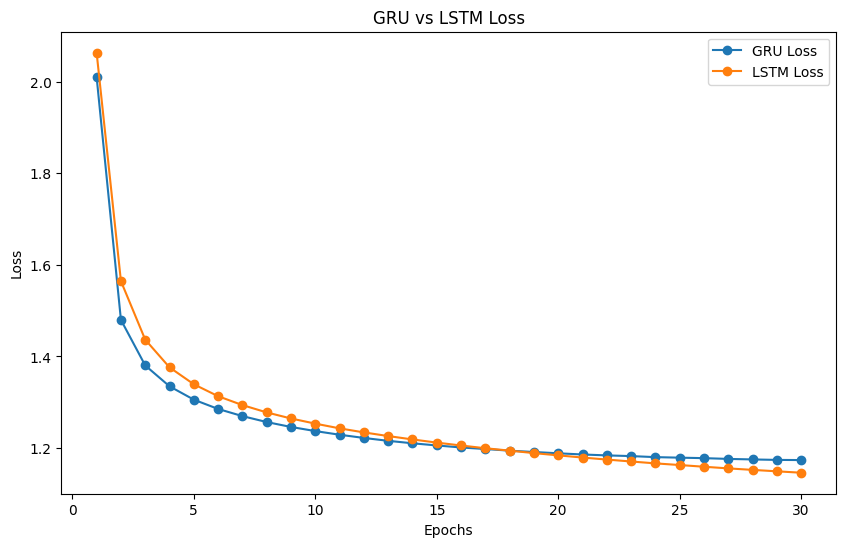

In [48]:
import matplotlib.pyplot as plt

# Extract loss values
loss_gru = history_gru.history['loss']
loss_lstm = history_lstm.history['loss']

# Define the range of epochs
epochs = range(1, EPOCHS + 1)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot GRU loss
plt.plot(epochs, loss_gru, label='GRU Loss', marker='o')

# Plot LSTM loss
plt.plot(epochs, loss_lstm, label='LSTM Loss', marker='o')

# Adding plot title and labels
plt.title('GRU vs LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

You can uncomment the following cell to save the weigthts of your model. This allows you to use the model later.

In [41]:
# # If you want, you can save the final model. Here is deactivated.
#output_dir = './your-model/'

#try:
#    shutil.rmtree(output_dir)
#except OSError as e:
#    pass

#model.save_weights(output_dir)


## 4 - Evaluation  

### 4.1 - Evaluating using the Deep Nets

To evaluate language models, we usually use perplexity which is a measure of how well a probability model predicts a sample. Note that perplexity is defined as:

$$P(W) = \sqrt[N]{\prod_{i=1}^{N} \frac{1}{P(w_i| w_1,...,w_{n-1})}}$$

As an implementation hack, we would usually take the log of that formula (to enable us to use the log probabilities we get as output of our `RNN`, convert exponents to products, and products into sums which makes computations less complicated and computationally more efficient).


$$\log P(W) = {\log\left(\sqrt[N]{\prod_{i=1}^{N} \frac{1}{P(w_i| w_1,...,w_{n-1})}}\right)}$$$$ = \log\left(\left(\prod_{i=1}^{N} \frac{1}{P(w_i| w_1,...,w_{n-1})}\right)^{\frac{1}{N}}\right)$$
$$ = \log\left(\left({\prod_{i=1}^{N}{P(w_i| w_1,...,w_{n-1})}}\right)^{-\frac{1}{N}}\right)$$$$ = -\frac{1}{N}{\log\left({\prod_{i=1}^{N}{P(w_i| w_1,...,w_{n-1})}}\right)} $$$$ = -\frac{1}{N}{{\sum_{i=1}^{N}{\log P(w_i| w_1,...,w_{n-1})}}} $$


### 5 - log_perplexity


In [42]:

def log_perplexity(preds, target):
    """
    Function to calculate the log perplexity of a model.

    Args:
        preds (tf.Tensor): Predictions of a list of batches of tensors corresponding to lines of text.
        target (tf.Tensor): Actual list of batches of tensors corresponding to lines of text.

    Returns:
        float: The log perplexity of the model.
    """
    PADDING_ID = 1


    # Calculate log probabilities for predictions using one-hot encoding
    log_p = np.sum(preds * tf.one_hot(target, depth=preds.shape[-1]), axis= -1) # HINT: tf.one_hot() should replace one of the Nones
    # Identify non-padding elements in the target
    non_pad = 1.0 - np.equal(target, PADDING_ID)          # You should check if the target equals to PADDING_ID
    # Apply non-padding mask to log probabilities to exclude padding
    log_p = log_p * non_pad                             # Get rid of the padding
    # Calculate the log perplexity by taking the sum of log probabilities and dividing by the sum of non-padding elements
    log_ppx = np.sum(log_p, axis=-1) / np.sum(non_pad, axis=-1) # Remember to set the axis properly when summing up
    # Compute the mean of log perplexity
    log_ppx = np.mean(log_ppx) # Compute the mean of the previous expression


    return -log_ppx

Now, we will use the 1000 lines of the corpus that were reserved at the begining of this notebook as test data. We will apply the same preprocessing as you did for the train dataset: get the numeric tensor from the input lines, and use the `split_input_target` to generate the inputs and the expected outputs.

Second, we will predict the next characters for the whole dataset, and we will compute the perplexity for the expected outputs and the given predictions.

In [43]:
#for line in eval_lines[1:3]:
eval_text = "\n".join(eval_lines)
eval_ids = line_to_tensor([eval_text], vocab)
input_ids, target_ids = split_input_target(tf.squeeze(eval_ids, axis=0))

preds_gru, status_gru = model_gru(tf.expand_dims(input_ids, 0), training=False, states=None, return_state=True)
preds_lstm, status_lstm = model_lstm(tf.expand_dims(input_ids, 0), training=False, states=None, return_state=True)
#Get the log perplexity
log_ppx_gru = log_perplexity(preds_gru, tf.expand_dims(target_ids, 0))
log_ppx_lstm = log_perplexity(preds_lstm, tf.expand_dims(target_ids, 0))
print(f'The log perplexity and perplexity of Our GRULM model are {log_ppx_gru} and {np.exp(log_ppx_gru)} respectively')
print(f'The log perplexity and perplexity of Our LSTMLM model are {log_ppx_lstm} and {np.exp(log_ppx_lstm)} respectively')

The log perplexity and perplexity of Our GRULM model are 1.21788068144193 and 3.3800168052226462 respectively
The log perplexity and perplexity of Our LSTMLM model are 1.1904782262372597 and 3.288653551798703 respectively



## 5 - Generating Language with our Own Models

The GRULM & LSTMLM models demonstrate an impressive ability to predict the most likely characters in a sequence, based on log scores. However, it's important to acknowledge that these models, in its default form, is deterministic and can result in repetitive and monotonous outputs. For instance, it tends to provide the same answer to a question consistently.

To make our language model more dynamic and versatile, we can introduce an element of randomness into its predictions. This ensures that even if we feed the model in the same way each time, it will generate different sequences of text.

To achieve this desired behavior, we can employ a technique known as random sampling. When presented with an array of log scores for the N characters in our dictionary, we add an array of random numbers to this data. The extent of randomness introduced into the predictions is regulated by a parameter called "temperature". By comparing the random numbers to the original input scores, the model adapts its choices, offering diversity in its outputs.

This doesn't imply that the models produces entirely random results on each iteration. Rather, with each prediction, there is a probability associated with choosing a character other than the one with the highest score. This concept becomes more tangible when you explore the accompanying Python code.

In [44]:
def temperature_random_sampling(log_probs, temperature=1.0):
    """Temperature Random sampling from a categorical distribution. The higher the temperature, the more
       random the output. If temperature is close to 0, it means that the model will just return the index
       of the character with the highest input log_score

    Args:
        log_probs (tf.Tensor): The log scores for each characeter in the dictionary
        temperature (number): A value to weight the random noise.
    Returns:
        int: The index of the selected character
    """
   # Generate uniform random numbers with a slight offset to avoid log(0)
    u = tf.random.uniform(minval=1e-6, maxval=1.0 - 1e-6, shape=log_probs.shape)

    # Apply the Gumbel distribution transformation for randomness
    g = -tf.math.log(-tf.math.log(u))

    # Adjust the logits with the temperature and choose the character with the highest score
    return tf.math.argmax(log_probs + g * temperature, axis=-1)


Now, it's time to bring all the elements together for the exciting task of generating new text. The GenerativeModel class plays a pivotal role in this process, offering two essential functions:

1. `generate_one_step`: This function is our go-to method for generating a single character at a time. It accepts two key inputs: an initial input sequence and a state that can be thought of as the ongoing context or memory of the model. The function delivers a single character prediction and an updated state, which can be used as the context for future predictions.

2. `generate_n_chars`: This function takes text generation to the next level. It orchestrates the iterative generation of a sequence of characters. At each iteration, generate_one_step is called with the last generated character and the most recent state. This dynamic approach ensures that the generated text evolves organically, building upon the context and characters produced in previous steps. Each character generated in this process is collected and stored in the result list, forming the final output text.


###  6 - GenerativeModel

We will create a function to generate a single character based on the input text, using the provided vocabulary and the trained model.

Follow these steps to complete the generate_one_step function:

1. Start by transforming our input text into a tensor using the given vocab. This will convert the text into a format that the model can understand.

2. Utilize the trained model with the input_ids and the provided states to predict the next characters. Make sure to retrieve the updated states from this prediction because they are essential for the final output.

3. Since we are only interested in the next character prediction, keep only the result for the last character in the sequence.

4. Employ the temperature random sampling technique to convert the vector of scores into a single character prediction. For this step, we will use the predicted_logits obtained in the previous step and the temperature parameter of the model.

5. To transform the numeric prediction into a human-readable character, we will use the text_from_ids function. Be mindful that text_from_ids expects a list as its input, so we need to wrap the output of the temperature_random_sampling function in square brackets [...]. Don't forget to use self.vocab as the second parameter for character mapping.

6. Finally, return the predicted_chars, which will be a single character, and the states tensor obtained from step 2. These components are essential for maintaining the sequence and generating subsequent characters.







In [45]:

class GenerativeModel(tf.keras.Model):
    def __init__(self, model, vocab, temperature=1.0):
        """
        A generative model for text generation.

        Args:
            model (tf.keras.Model): The underlying model for text generation.
            vocab (list): A list containing the vocabulary of unique characters.
            temperature (float, optional): A value to control the randomness of text generation. Defaults to 1.0.
        """
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.vocab = vocab

    @tf.function
    def generate_one_step(self, inputs, states=None):
        """
        Generate a single character and update the model state.

        Args:
            inputs (string): The input string to start with.
            states (tf.Tensor): The state tensor.

        Returns:
            tf.Tensor, states: The predicted character and the current GRU state.
        """
        # Convert strings to token IDs.



        # Transform the inputs into tensors
        input_ids = line_to_tensor(inputs, vocab)
        # Predict the sequence for the given input_ids. Use the states and return_state=True
        predicted_logits, states = self.model(input_ids, states, return_state=True)
        # Get only last element of the sequence
        predicted_logits = predicted_logits[0, -1, :]
        # Use the temperature_random_sampling to generate the next character.
        predicted_ids = temperature_random_sampling(predicted_logits, self.temperature)
        # Use the chars_from_ids to transform the code into the corresponding char
        predicted_chars = text_from_ids([predicted_ids], vocab)

        # Return the characters and model state.
        return tf.expand_dims(predicted_chars, 0), states

    def generate_n_chars(self, num_chars, prefix):
        """
        Generate a text sequence of a specified length, starting with a given prefix.

        Args:
            num_chars (int): The length of the output sequence.
            prefix (string): The prefix of the sequence (also referred to as the seed).

        Returns:
            str: The generated text sequence.
        """
        states = None
        next_char = tf.constant([prefix])
        result = [next_char]
        for n in range(num_chars):
            next_char, states = self.generate_one_step(next_char, states=states)
            result.append(next_char)

        return tf.strings.join(result)[0].numpy().decode('utf-8')

In [46]:

# Fix the seed to get replicable results for testing



tf.random.set_seed(272)
gen = GenerativeModel(model_gru, vocab, temperature=0.5)
gen2 = GenerativeModel(model_lstm, vocab, temperature=0.5)
print("GRULM--------------------------------------------------------------------------------------------------------")
print(gen.generate_n_chars(32, " "), '\n\n' + '_'*80)
print(gen.generate_n_chars(32, "Dear"), '\n\n' + '_'*80)
print(gen.generate_n_chars(32, "KING"), '\n\n' + '_'*80)
print("LSTMLM--------------------------------------------------------------------------------------------------------")
print(gen2.generate_n_chars(32, " "), '\n\n' + '_'*80)
print(gen2.generate_n_chars(32, "Dear"), '\n\n' + '_'*80)
print(gen2.generate_n_chars(32, "KING"), '\n\n' + '_'*80)

GRULM--------------------------------------------------------------------------------------------------------
 me in the storm?
DUCHESS OF YORK 

________________________________________________________________________________
Dear morning, then, and say 'tis the 

________________________________________________________________________________
KINGHAM	God pluck the market-place,  

________________________________________________________________________________
LSTMLM--------------------------------------------------------------------------------------------------------
 hear me speak to me,
And so the  

________________________________________________________________________________
Dear Clarence,
Who begg'd his tears, 

________________________________________________________________________________
KING OF GLOUCESTER	I think I should  

________________________________________________________________________________


Now, generate a longer text. Let's check if it looks like Shakespeare fragment

In [47]:
# PS : we will  only generate 1000 chars
tf.random.set_seed(np.random.randint(1, 1000))
print("GRULM--------------------------------------------------------------------------------------------------------")
gen = GenerativeModel(model_gru, vocab, temperature=0.8)
import time
start = time.time()
print(gen.generate_n_chars(1000, "ROMEO "), '\n\n' + '_'*80)
print('\nRun time:', time.time() - start)
print("LSTMLM--------------------------------------------------------------------------------------------------------")
gen = GenerativeModel(model_lstm, vocab, temperature=0.8)
import time
start = time.time()
print(gen.generate_n_chars(1000, "ROMEO "), '\n\n' + '_'*80)
print('\nRun time:', time.time() - start)

GRULM--------------------------------------------------------------------------------------------------------
ROMEO AND, Keepest of Ephesus]
GRATIANO	If she did show your own clowns and thee,
That Publius Pisoled chamber with me and in
The officer of the news is Clarence Show.
But I forgive thee in my rest of love.
You mark her? say to Warwick's officers?
Second Keeper	[Aside]  Then if the while you may not weigh
And please you that way saying like the
cow to be whirl thou pitchesy and love and
live with the tabbors to the wages:
there is a witty wit to love: what's the news?
EDGAR	Why, what rage?
POMPEY	You will be with you.
TITUS ANDRONICUS	Ay, but my father's estate to see thy sakeness:
Thou wouldst advance their daughters for my rest,
And let the emperor I will for thine,
Whose name is a kind of man; for I to her
Unto the murken to a million a little
herald; they are not dead? who can renown the sea?
Gentleman	Ay, Desdemona.
GOWER	It is the time to live.
HORTENSIO	I will far him to

In the generated text above, you can see that the models generates text that makes sense capturing dependencies between words and without any input. A simple n-gram model would have not been able to capture all of that in one sentence.